# Analyzing radial velocity timeseries with DACE tools
## DACE - python APIs

## Author
Jean-Baptiste Delisle (DACE data scientist) with additions from Nathan Hara.


## Summary
This tutorial demonstrates the use of the python DACE APIs and associated packages
to download, visualize and analyze radial velocity timeseries.

These packages offer additional capabilities to the DACE graphical interface, such as the use of correlated noise models in periodograms, fits and MCMC. The noise models are defined as S-LEAF covariances ([Delisle, Hara, Ségransan 2020, A&A, in press](https://doi.org/10.1051/0004-6361/201936906)) and the periodograms are defined as in [Delisle, Hara, Ségransan 2020, A&A, 635, A83](https://doi.org/10.1051/0004-6361/201936905).

This tutorial includes
* Packages installation with **pip install**
2. Downloading radial velocity timeseries using DACE APIs
3. Defining a model
4. Looking for planetary signals using a periodogram (+ FAP) approach
5. Fitting model parameters
6. Launching a MCMC

Mathematical definitions of the concepts used are given when relevant **<font color='navy'> in navy blue font <font color='black'>**. These sections are given for the sake of completeness. It is not necessary to read those to complete this tutorial. 


## Requirements
python 3, matplotlib, numpy, scipy, astroquery  
**python-dace-client, spleaf, kepderiv, corner** (see below for installation instructions)

## Packages installation

**Install DACE APIs** (see also [DACE APIs installation tutorial](https://dace.unige.ch/tutorials/?tutorialId=10)):  
`pip install --extra-index-url https://dace.unige.ch/api python-dace-client`

**Install astroquery**:  
`pip install --pre astroquery`

**Install spleaf**:  
`pip install --extra-index-url https://obswww.unige.ch/~delisle spleaf`

**Install kepderiv**:  
`pip install --extra-index-url https://obswww.unige.ch/~delisle kepderiv`

**Install corner**:  
`pip install corner`

    

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dace.spectroscopy import Spectroscopy
from astroquery.simbad import Simbad
from rvmodel import *
import corner

## Settings
Define
- The target to analyse
- The instruments from which the data comes from
- The stellar activity indicators
- Several options for the analysis: detection, fitting routines, MCMC options...

In [2]:
# Data settings
target =  'Sagan_system1'

# Instruments
instruments = []#[('HARPS03', '3.5', 'HARPS')] # By default select all available instruments
inst_sec_acc = {} # Keep default settings for secular correction for each instrument
inst_jitter = {} # Keep default settings for instruments jitter
epoch_rjd = 55500 # Reference epoch

#Binning
same_night_criterion = 0.7 #<---------------------------- Binning time-scale

# drift power: add a constant (dpow = 0), a constant + linear drift (dpow = 1), etc.
dpow = 0 

# Detrending
indicators = ['rhk'] #Choose the activity indicators (for instance 'rhk', 'fwhm')
indic_kernel_smoother = [tools.gaussian_kernel]#Kernel to filter the indicator chosen
indic_filter_timescale_yr = [0.5]  #Time-scale of the filter
indic_filter_type = ['low']   #low-pass or high pass filter ('low' or 'high') 

# Periodogram settings
# The periodogram is computed between periods min and Pmax for nfreq equispaced *frequencies* (not equispaced periods)
Pmin = 0.6
Pmax = 10000
nfreq = 100000
nu0 = 2 * np.pi / Pmax
dnu = (2 * np.pi / Pmin - nu0) / (nfreq - 1)

# Planet detection settings
fap_max = 1e-3  # Planet search stops if the maximum peak of the periodogram has a false alarm probability (FAP) > fap_max 
max_pla = 5 # The planet search stops when the number of significant signals equals max_pla 

# Fit options
# WARNING: the fit algorithm has not been extensively tested.
# There is room for improvements
# (better choice of minimization algorithm and/or options, ...)
fit_method = 'L-BFGS-B'
fit_options = {
    'maxiter': 1000,
    'maxcor': 50
}
start_fit_jitter_at_step = 0
fit_ecc = True

# MCMC options
nsamples = 100000

## Load data

We create a disctionary `rv_data` that contains all the time series that we will use in the analysis. 


We here to import the data and clean it. That is 
- Removing the points whose DRS quality check flagged as problematic by the data reduction software (DRS) 
- Removing instruments for which there is no data, no error bars, or one of the chosen activity indicator in the dictionary `indicators` is unavailable

In [3]:
# Create the dictionary that will contain the data to analyse
rv_data = {} 

# Download data
data_from_Dace = Spectroscopy.get_timeseries(target, sorted_by_instrument=True)

# Select all available instruments (if instruments are not specified by user)
if instruments == []:
    for inst in data_from_Dace:
        for drs in data_from_Dace[inst]:
            for mode in data_from_Dace[inst][drs]:
                instruments.append((inst,drs,mode))
ninst = len(instruments)

print('Downloaded data (data_from_Dace) keys:')
print(data_from_Dace.keys())

print('\nList of instruments before cleaning:')
print(instruments)

# Re-organize data
for kinst, inst in enumerate(instruments):
    data_inst = data_from_Dace[inst[0]][inst[1]][inst[2]]
    if kinst == 0:
        rv_data['inst_id'] = np.zeros_like(data_inst['rjd'], dtype=int)
        for key in data_inst:
            try:
                if key == 'drs_qc': #qc: quality check
                    rv_data[key] = np.array(data_inst[key], dtype=bool)    
                else:
                    rv_data[key] = np.array(data_inst[key], dtype=float)
            except:
                rv_data[key] = np.array(data_inst[key])
                pass
    else:
        rv_data['inst_id'] = np.concatenate((
            rv_data['inst_id'],
            np.full_like(data_inst['rjd'], kinst, dtype=int)))
        for key in data_inst:
            rv_data[key] = np.concatenate((rv_data[key], np.array(data_inst[key], dtype=rv_data[key].dtype)))

nt = rv_data['rjd'].size
print('\nNumber of points before cleaning:', nt)

# DRS quality check + nans
for key in rv_data:
    if rv_data[key].dtype == float:
        rv_data[key][rv_data[key]==-99999] = np.nan

# ------- Remove outliers -------
outlier_mad_condition = 4
not_an_outlier = rv_data['drs_qc']
for kinst in range(ninst):
    rvinst = rv_data['rv'][rv_data['inst_id']==kinst]
    dm = np.abs(rvinst- np.median(rvinst))
    mad = np.median(dm)
    not_an_outlier[rv_data['inst_id']==kinst] = dm<outlier_mad_condition*mad      
keep_crit = rv_data['drs_qc'] & not_an_outlier


for key in ['rv', 'rv_err'] + indicators:
    keep_crit = keep_crit & (rv_data[key] == rv_data[key])
for key in rv_data:
    rv_data[key] = rv_data[key][keep_crit]


# Remove empty instruments
# WARNING : removes the instruments for which the time series listed in the 'indicators' list are unavailable.
keep_inst = []
for kinst in range(ninst):
    if kinst in rv_data['inst_id']:
        keep_inst.append(kinst)
ninst = len(keep_inst)
instruments = [instruments[kinst] for kinst in keep_inst]
for newk, oldk in enumerate(keep_inst):
    rv_data['inst_id'][rv_data['inst_id']==oldk] = newk

# Sort by increasing time
ksort = np.argsort(rv_data['rjd'])
for key in rv_data:
    rv_data[key] = rv_data[key][ksort]

nt = rv_data['rjd'].size
print('Number of points after cleaning:', nt)
print('\nList of instruments kept after cleaning:')
print(instruments)
print('\nList of available fields:')
print(rv_data.keys())

Downloaded data (data_from_Dace) keys:
dict_keys(['CORAVEL', 'HARPS03'])

List of instruments before cleaning:
[('CORAVEL', '2020 Sagan Summer Workshop', 'default'), ('HARPS03', '2020 Sagan Summer Workshop', 'default')]

Number of points before cleaning: 3069
Number of points after cleaning: 2995

List of instruments kept after cleaning:
[('HARPS03', '2020 Sagan Summer Workshop', 'default')]

List of available fields:
dict_keys(['inst_id', 'caindex', 'caindex_err', 'protm08', 'protm08_err', 'berv', 'berv_err', 'drift_noise', 'drift_noise_err', 'bispan', 'bispan_err', 'texp', 'texp_err', 'fwhm', 'fwhm_err', 'cal_therror', 'cal_therror_err', 'rjd', 'rjd_err', 'rv', 'rv_err', 'ccf_noise', 'ccf_noise_err', 'rhk', 'rhk_err', 'mask', 'raw_file', 'naindex', 'naindex_err', 'snca2', 'snca2_err', 'pub_reference', 'contrast', 'contrast_err', 'cal_thfile', 'spectroFluxSn50', 'spectroFluxSn50_err', 'sindex', 'sindex_err', 'drs_qc', 'haindex', 'haindex_err', 'protn84', 'protn84_err', 'public', 'spec

## Secular correction

In [4]:
# Query Simbad for parallax and proper motion
#simb = Simbad()
#simb.reset_votable_fields()
#simb.add_votable_fields('plx', 'pmra', 'pmdec')
#target_info = simb.query_object(target)
#parallax_mas = target_info['PLX_VALUE'] # 28.497400
#pmra_mas_yr = target_info['PMRA'] # -27.951
#pmdec_mas_yr = target_info['PMDEC'] # -160.436

# Compute secular acceleration
#secacc = tools.computeSecAcc(parallax_mas, pmra_mas_yr, pmdec_mas_yr)
#for kinst, inst in enumerate(instruments):
#    if inst[0] in inst_sec_acc:
#        apply_sec = inst_sec_acc[inst[0]]
#    elif inst[0] in default_inst_sec_acc:
#        apply_sec = default_inst_sec_acc[inst[0]]
#    else:
#        apply_sec = default_inst_sec_acc['default']
#    if apply_sec:
#        rv_data['rv'] -= (rv_data['rjd'] - epoch_rjd) * secacc * (rv_data['inst_id']==kinst)

## Plot timeseries

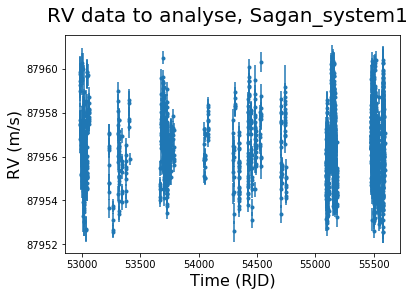

In [5]:
plt.figure()
for kinst in range(ninst):
    plt.errorbar(
        rv_data['rjd'][rv_data['inst_id']==kinst],
        rv_data['rv'][rv_data['inst_id']==kinst],
        yerr= rv_data['rv_err'][rv_data['inst_id']==kinst],# rv_err[rv_data['inst_id']==kinst],
        fmt='.', rasterized=True)
plt.xlabel('Time (RJD)',fontsize = 16)
plt.ylabel('RV (m/s)',fontsize = 16)
plt.suptitle('RV data to analyse, {}'.format(target),fontsize = 20)
plt.show()
plt.close()

# Analysis


    
The structure of the following RV analysis is to search for planet with a periodogram. If a significant signal is found, it is fitted with a Keplerian model and a linear activity model along with the noise parameters. We then search for a second signal in the residuals, if a a significant signal is found, we add a Keplerian signal to the model, which is fitted. We search for a third planet in the residuals and so on. 


## Set noise model

We here set the class `rv_model`, which contains the data and the methods to analyse it. 
We first need to define the noise model. 


---------- 
<font color='navy'>
   
The noise is defined as a covariance kernel as in Delisle, Hara, Ségransan 2020, A&A. The element $C_{i,j}$ of the covariance is defined as
$$
C_{i,j} = (\sigma_i^2 + \sigma_J(i)^2) \delta_{i,j} + \sigma_C^2 c_{i,j}+ \sum\limits_{k=1}^{n_\mathrm{e}}\sigma_{e,k}^2 \mathrm{e}^{-\lambda_k|t_i-t_j|}+  \sum\limits_{s=1} ^{n_\mathrm{qp}}
\left(a_s \cos(\nu_s|t_i-t_j|) + b_s \sin(\nu_s |t_i-t_j|) \right) \mathrm{e}^{-\lambda_s|t_i-t_j|}.
\tag{1}
$$
   
where $t_i$ is the time of measurement #$i$, $\delta_{i,j} =1$ if $i=j$ and =  0 otherwise.  $c_{i,j} = 1$ if measurements $i$ and $j$ share the same calibration. We have also 
- The nominal uncertainty on measurement $i$, $\sigma_{i,j}$. Set `var_exp`, `lambda_exp` in `rvModel`.
- An additional jitter per instrument $\sigma_{J}(i)$. Set `var_jitter_inst` in `rvModel`.
- A calibration noise term $\sigma_{C}$, for all measurements taken with the same calibration reference.
- Exponential decays. One can specify several of them with amplitude and inverse time-scales $\sigma_{e,k}, \lambda_k$, $k=1..n_e$. Set `var_exp`, `lambda_exp` in `rvModel`.
- Quasi-periodic components defined by the quantities $a_s$, $b_s$, $\nu_s$, $\lambda_s$ setting the amplitude and phase, frequency and decay time-scale. Set `var_cos_qper`, `var_sin_qper`, `nu_qper`, `lambda_qper` in `rvModel`.
    
The form of the covariance (1) allows to solve equations $Cx = y$ in $0(N)$ operations instead of $0(N^2)$. One can define even more general expressions with S-LEAF matrices, but this is beyond the scope of the present paper. Note that (1) can be seen as a CELERITE kernel [Foreman-Mackey, Agol, Ambikasaran, Angus 2017, AJ](https://iopscience.iop.org/article/10.3847/1538-3881/aa9332), except for the calibration noise. 



<font color='red'>
    
## New: binning the data or creating calibration noise
 
Define a list of strings that has the dimension of the initial data such that if two components are equal, the observations correspond to the same night. This can be used to define a calibration noise component in the covariance matrix. 
    
Bin the RV data points that belong to the same night. 
    
Beware that it makes more sense not to both create a calibration noise and bin the data, but to choose one or the other. Pay attention in the two following blocks which lines to comment/uncomment for each alternative.
    
In this exaxmple the data is binned by default.
    

In [6]:
# Spotting the points which are taken within the same night
nobs = len(rv_data['rjd'])
nights_labels = np.array(['0']*nobs, dtype=object)

c = 0
for kinst in range(ninst):
    tinst = rv_data['rjd'][rv_data['inst_id']==kinst]
    n = len(tinst)
    nights = np.array(['0']*n, dtype=object)
    c += 1
    i0 = 0
    for i in range(n-1):
        if np.abs(tinst[i+1] - tinst[i0])<same_night_criterion:
            nights[i+1] = nights[i]
        else:
            c +=1
            nights[i+1] = str(c)
            i0 = i+1
    nights_labels[rv_data['inst_id']==kinst] = nights

# You can use this information to create calibration noise blocks in the covariance or to bin the data

# 1) Creating calibration noise
var_calib_meas = np.ones(nobs)*0.75
calib_file = nights_labels

# 2) Binning the data
print('number of points before binning', nobs)    
err2 = rv_data['rv_err']**2
rv_data_binned = rv_data.copy()

for key in rv_data:
    binned_timeseries = []
    nightschecked = []
    for s in nights_labels:
        if s not in nightschecked:       
            condition = nights_labels==s
            timeseries = rv_data[key][condition]
            err2s = err2[condition]
            try:
                timeseriesbin = np.sum(timeseries/err2s) / np.sum(1/err2s)
                binned_timeseries.append(timeseriesbin)
            except:
                None   
            nightschecked.append(s)
    try:
        rv_data_binned[key] = np.array(binned_timeseries)   
    except:
        None   
print('number of points after binning', len(rv_data_binned['rv']))        

#Bin the data
initial_rv_data = rv_data.copy() # <--------- comment the line if you do not want to bin the data
rv_data = rv_data_binned   # <--------- comment the line if you do not want to bin the data
rv_data['inst_id'] =rv_data['inst_id'].astype(int)


number of points before binning 2995
number of points after binning 187


In [7]:
var_jitter = []
for inst in instruments:
    if inst[0] in inst_jitter:
        var_jitter.append(inst_jitter[inst[0]]**2)
    elif inst[0] in default_inst_jitter:
        var_jitter.append(default_inst_jitter[inst[0]]**2)
    else:
        var_jitter.append(default_inst_jitter['default']**2)
var_jitter = np.array(var_jitter)

rv_model = rvModel(
    rv_data['rjd']-epoch_rjd,
    rv_data['rv'],
    rv_data['rv_err']**2,
    inst_id=rv_data['inst_id'],
    var_jitter_inst=var_jitter,
  var_cos_qper=np.array([]), # No quasi periodic component
  var_sin_qper=np.array([]),
  lambda_qper=np.array([]),
  nu_qper=np.array([]),
  var_exp = np.array([1.0]),
  lambda_exp = np.array([1/1.0]),  # Noise time scale is 1 day
#    var_calib_meas = var_calib_meas, #<------ Un-comment if you want to create a calibration noise
#    calib_file = calib_file,      #<------ Un-comment if you want to create a calibration noise
)

rv_err = np.sqrt(rv_model.cov.A)

## Linear parameters

We set a linear model that is included by default in our signal model. This includes offsets between different instruments, trends, activity predictors. We here use a smoothed activity indicator to model the stellar activity. 


Plot activity indicator: rhk_low


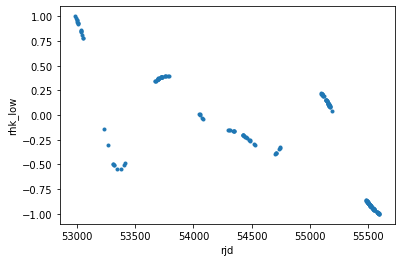

Fit linear parameters:
Parameter                        Value     Error       
lin.offset_inst_0            87956.423  ±  0.117       
lin.rhk_low                      0.270  ±  0.188       

loglikelihood = -293.86556822294307


In [8]:
# Add linear parameters
for kinst in range(ninst):
    rv_model.addlin(1.0*(rv_data['inst_id']==kinst), 'offset_inst_{}'.format(kinst))
for kpow in range(dpow):
    rv_model.addlin(rv_model.t**(kpow+1), 'drift_pow{}'.format(kpow+1))
for kind, indic in enumerate(indicators):
    tmp = rv_data[indic].copy()
    if indic_kernel_smoother[kind] is not None:
        tmp_smooth = tools.smooth_series(
            rv_data['rjd']/(365.25*indic_filter_timescale_yr[kind]),
            tmp,
            indic_kernel_smoother[kind])
        if indic_filter_type[kind] == 'high':
            tmp -= tmp_smooth
        else:
            tmp = tmp_smooth
    tmpmx = tmp.max()
    tmpmn = tmp.min()
    tmp = 2.0*(tmp-tmpmn)/(tmpmx-tmpmn) - 1.0
    indic_name = indic
    if indic_filter_type[kind] is not None:
        indic_name += "_" + indic_filter_type[kind]
    rv_model.addlin(tmp, indic_name)
    print('Plot activity indicator: {}'.format(indic_name))
    plt.figure()
    for kinst in range(ninst):
        plt.plot(rv_data['rjd'][rv_data['inst_id']==kinst],
                 tmp[rv_data['inst_id']==kinst],
                 '.', rasterized=True)
    plt.xlabel('rjd')
    plt.ylabel(indic_name)
    plt.show()
    plt.close()    
print("Fit linear parameters:")
rv_model.fit(method=fit_method,options=fit_options)
rv_model.show_params()
print('loglikelihood =', rv_model.loglike())

## Fit instruments jitter

We here select which noise parameters are fitted by adding them to the variable `rv_model.fitparams`.

In [9]:
jitter_params = ['cov.var_jitter_inst.{}'.format(kinst) for kinst in range(ninst)]
if start_fit_jitter_at_step == 0:
    #rv_model.fitparams += jitter_params # We add the jitters, but leave the exponential decay fixed. 
    rv_model.fit(method=fit_method,options=fit_options)
    rv_model.show_params()
    print('loglikelihood =', rv_model.loglike())

Parameter                        Value     Error       
lin.offset_inst_0            87956.423  ±  0.117       
lin.rhk_low                      0.270  ±  0.188       

loglikelihood = -293.86556822294307


## Iterative search for planets

 We compute the periodogram of the data, fit the signals found, compute the peridogram of residuals and so on. 
    
<font color='navy'>
    
### Periodograms
#### General concepts

Let us suppose we have a time series of $N$ observations, sampled, possibly unevenly, at times $t = (t_i)_{i=1..N}$. We denote this time series by $y = (y(t_i))_{i=1..N}$.

We now might want to study the spectral content of $y$, for instance we might consider the question: does it contain periodic component? or what is its power spectral density? Periodograms are made to study these questions. 

There exists numerous variants of the periodogram<sup>1</sup>. Most of these include the following three "ingredients": 
- A frequency grid: $(\omega_k)$: every frequency of the grid is a candidate
- A noise model : what is the covariance of the noise? 
- A base model: at each frequency $\omega$ in the grid, one compares the base model $H$ (for example an offset) to a model $K_\omega$, that includes $H$ and a sinusoidal function at frequency $\omega$. 

The models $H$ and $K_\omega$ are then compared in terms of their maximum likelihoods. Simply put, one fits model $H$ and $K_\omega$ for all $\omega$ and compares the fit quality. This comparison can be made in a precise sense, that we'll come back to later on. 


#### General linear periodograms

To make things precise, we use the framework of Delilse, Hara, Ségransan 2020, A&A, generalizing Baluev 2008, MNRAS, which offers a compromise between simplicity and generality. It naturally allows to handle offsets between different instruments, trends, activity and correlated noise.

We consider: 
- A grid of frequencies: $(\omega_k)_{k=1..N_\omega}$ 
- A covariance matrix $V$
- A base model

$$ H (x): y = \phi_H x + \epsilon $$ 

where $\epsilon$ is a Gaussian noise of covariance matrix $V$ and $\phi_H$ is a fixed $N\times p$ matrix. The alternative model is 

$$ K_\omega (x,A,B): y  = \phi_H x + A\cos \omega t + B\sin \omega t +\epsilon  = [\phi_H, \cos \omega t, \sin \omega t] \left[ \begin{array}{c}x \\ A \\ B \end{array}\right] +\epsilon $$ 
Let us denote by $\phi_K(\omega)$ the matrix $$ \phi_K(\omega) = [\phi_H, \cos \omega t, \sin \omega t],$$
where $\cos \omega t $ is a column whose $i$-th element is $\cos\omega t_i.$ 
$$ K_\omega: y  = \phi_K(\omega) x + \epsilon $$ 

One can compare the likelihoods  of $H$ and $K_\omega$ maximized over their parameters (x and x, A, B). 
The models $H$ and $K_\omega$ are linear, and the noise is fixed and Gaussian. This means that maximising the likelihood is equivalent to minimising the $\chi^2$ of the residuals. A possible definition of the periodogram is 

$$ P(\omega) = \frac{\chi^2_{H} - \chi^2_{K_\omega}}{\chi^2_{H}}  $$

where $\chi^2_{M}$ is the $\chi^2$ of the residuals after fitting model $M$. 

    
#### False alarm probability 
The false alarm probability (FAP) is defined as follows. Suppose the maximum power of the periodogram of the data computed on a frequency grid $\Omega$ is $P^\star$. The FAP is the probability that the maximum peak of the periodogram computed on $\Omega$ exceeds $P^\star$ under the hypothesis $H$. In other words, if the signal was pure noise + model H, what would be the probability to observe a maximum peak at least as high?  
    
Thanks to the theory of extreme values of stochastic processes, one can obtain an analytical approximation of the False alarm probability based on $P^\star$, the timespan of the observations and the width of the frequency grid (see Baluev 2008 and Delisle, Hara, Ségansan 2020). 

-----------

<sup>1</sup>The origin of the periodogram concept is often cited to be Schuster 1898, which defines it as the squared modulus of the Fourier transform. There have been also definitions as $\chi^2$ of the residuals after fitting a sinusoid function (Lomb 1976, Scargle 1982). Some authors include a variable offset in the fit (Ferraz-Melo 1981, Cumming 1999, Zechmeister & Kürster 2009). One can also include a more general linear model (Baluev 2008) or non linear model (Anglada Escudé & Tuomi 2012), a free jitter term (Baluev 2009), several frequencies (Baluev 2013 a), a Keplerian periodogram (Baluev 2015) a non-sinusoidal family of periodic functions (Baluev 2013 b), and many more.
    
<font color='black'>

Plot residuals:


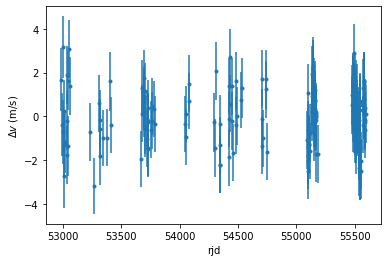

Periodogram of residuals:


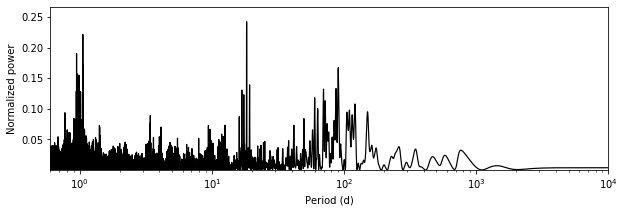

Highest periodogram peak:
P=18.304757378967075 d, power=0.2421901948194527, FAP=2.6330343684193556e-07

Fit all parameters:
Parameter                        Value     Error       
lin.offset_inst_0            87956.368  ±  0.118       
lin.rhk_low                      0.239  ±  0.189       
pla.0.n                       0.343213  ±  0.000118    
pla.0.la0                        3.870  ±  0.220       
pla.0.K                          0.981  ±  0.183       
pla.0.k                          0.367  ±  0.180       
pla.0.h                         -0.183  ±  0.176       

loglikelihood = -275.0138260751037

Plot residuals:


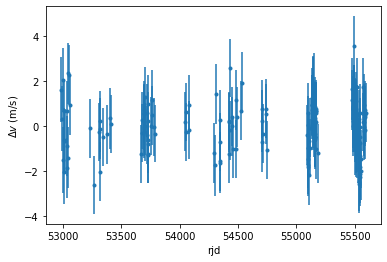

Periodogram of residuals:


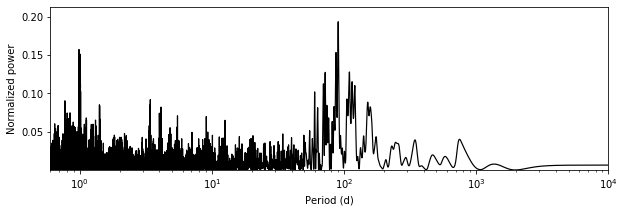

Highest periodogram peak:
P=90.23003475094154 d, power=0.19356718578302856, FAP=6.753162942529922e-05

Fit all parameters:
Parameter                        Value     Error       
lin.offset_inst_0            87956.287  ±  0.129       
lin.rhk_low                      0.444  ±  0.204       
pla.0.n                       0.343194  ±  0.000106    
pla.0.la0                        3.847  ±  0.222       
pla.0.K                          0.993  ±  0.186       
pla.0.k                          0.420  ±  0.147       
pla.0.h                         -0.239  ±  0.163       
pla.1.n                       0.069633  ±  0.000161    
pla.1.la0                       -0.048  ±  0.293       
pla.1.K                          0.939  ±  0.205       
pla.1.k                         -0.071  ±  0.226       
pla.1.h                         -0.395  ±  0.161       

loglikelihood = -262.3345266166509

Plot residuals:


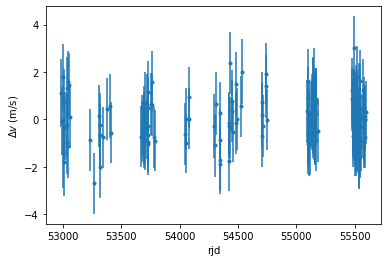

Periodogram of residuals:


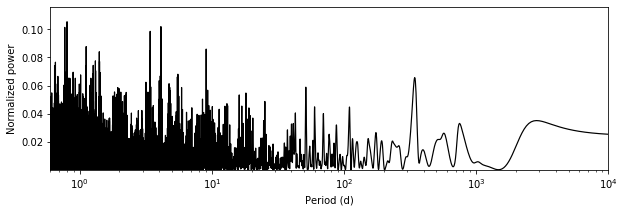

Highest periodogram peak:
P=0.8028875737834194 d, power=0.10537846908860571, FAP=0.46711797428430224

Stopping here (non-significant detection)


In [10]:
for _ in range(max_pla):
    # Plot residuals
    print('Plot residuals:')
    res = rv_model.residuals()
    rv_err = np.sqrt(rv_model.cov.A)
    plt.figure()
    for kinst in range(ninst):
        plt.errorbar(
            rv_data['rjd'][rv_data['inst_id']==kinst],
            res[rv_data['inst_id']==kinst],
            yerr=rv_err[rv_data['inst_id']==kinst],
            fmt='.', rasterized=True)
    plt.xlabel('rjd')
    plt.ylabel('$\Delta v$ (m/s)')
    plt.show()
    plt.close()
    # Compute periodogram
    print('Periodogram of residuals:')
    nu, power = rv_model.periodogram(nu0, dnu, nfreq)
    P = 2 * np.pi / nu
    # Compute FAP
    kmax = np.argmax(power)
    faplvl = rv_model.fap(power[kmax], nu.max())
    # Plot periodogram
    plt.figure(figsize=(10, 3))
    plt.plot(P, power, 'k', lw=1.2, rasterized=True)
    plt.xlim(Pmin, Pmax)
    plt.ylim(power.min(), 1.1 * power.max())
    plt.xscale('log')
    plt.xlabel('Period (d)')
    plt.ylabel('Normalized power')
    plt.show()
    plt.close()
    # Show results
    print('Highest periodogram peak:')
    print('P={} d, power={}, FAP={}\n'.format(P[kmax], power[kmax], faplvl))
    if faplvl > fap_max:
        print('Stopping here (non-significant detection)')
        break    
    print('Fit all parameters:')
    # Add new planet
    rv_model.smartaddpla(P[kmax])
    
    #change for parameters for which the fits are better behaved (k=e*cos w, h=e*sin w)
    rv_model.changeparpla(rv_model.planame[-1], params=['n', 'la0', 'K', 'k', 'h']) 

    if not fit_ecc: #If the orbits are assumed circular
        rv_model.set_params(np.zeros(2), rv_model.fitparams[-2:])
        rv_model.fitparams = rv_model.fitparams[:-2]
    # Add jitter to fitparams if needed
    if rv_model.npla == start_fit_jitter_at_step:
        rv_model.fit(method=fit_method, options=fit_options)
        rv_model.fitparams += jitter_params
    # Global fit of the model
    rv_model.fit(method=fit_method, options=fit_options)
    rv_model.show_params()
    print('loglikelihood = {}\n'.format(rv_model.loglike()))

## Phase folding

Planet 0 (18.308 d)


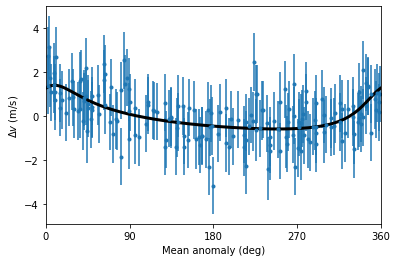

Planet 1 (90.233 d)


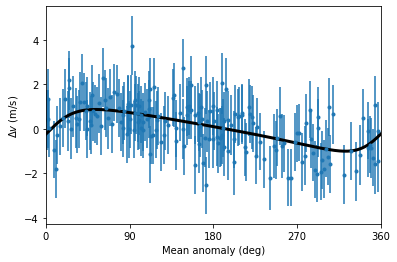

In [11]:
res = rv_model.residuals()
rv_err = np.sqrt(rv_model.cov.A)

for kpla, pla in enumerate(rv_model.kep):
    params = pla.get_param()
    rv_model.changeparpla(rv_model.planame[kpla], params=['n', 'M0', 'K', 'k', 'h']) # M0: mean motion at t = epoch_rjd
    n = rv_model.get_params('pla.{}.n'.format(kpla))
    M0 = rv_model.get_params('pla.{}.M0'.format(kpla))
    #rv_model.changeparpla(rv_model.planame[kpla], params=params)
    M = (M0 + n*rv_model.t)*180/np.pi % 360
    Mmod = np.linspace(0,360,1000)
    tmod = (Mmod*np.pi/180-M0)/n
    print('Planet {} ({:.3f} d)'.format(kpla, 2*np.pi/n))
    plt.figure()
    plt.xlim(0,360)
    plt.xticks([0,90,180,270,360])
    plt.plot(Mmod, pla.rv(tmod), 'k', lw=3, rasterized=True)
    for kinst in range(ninst):
        plt.errorbar(
            M[rv_data['inst_id']==kinst],
            (res+pla.rv(rv_model.t))[rv_data['inst_id']==kinst],
            yerr=rv_err[rv_data['inst_id']==kinst],
            fmt='.', rasterized=True)
    plt.xlabel('Mean anomaly (deg)')
    plt.ylabel('$\Delta v$ (m/s)')
    plt.show()
    plt.close()

## Launch MCMC

In [12]:
samples, diagnos = rv_model.sample(nsamples=nsamples, logprior=lambda fitparams, x:0)

Step 100000, acceptance rate (since last printing): 0.2070 


## Corner plot

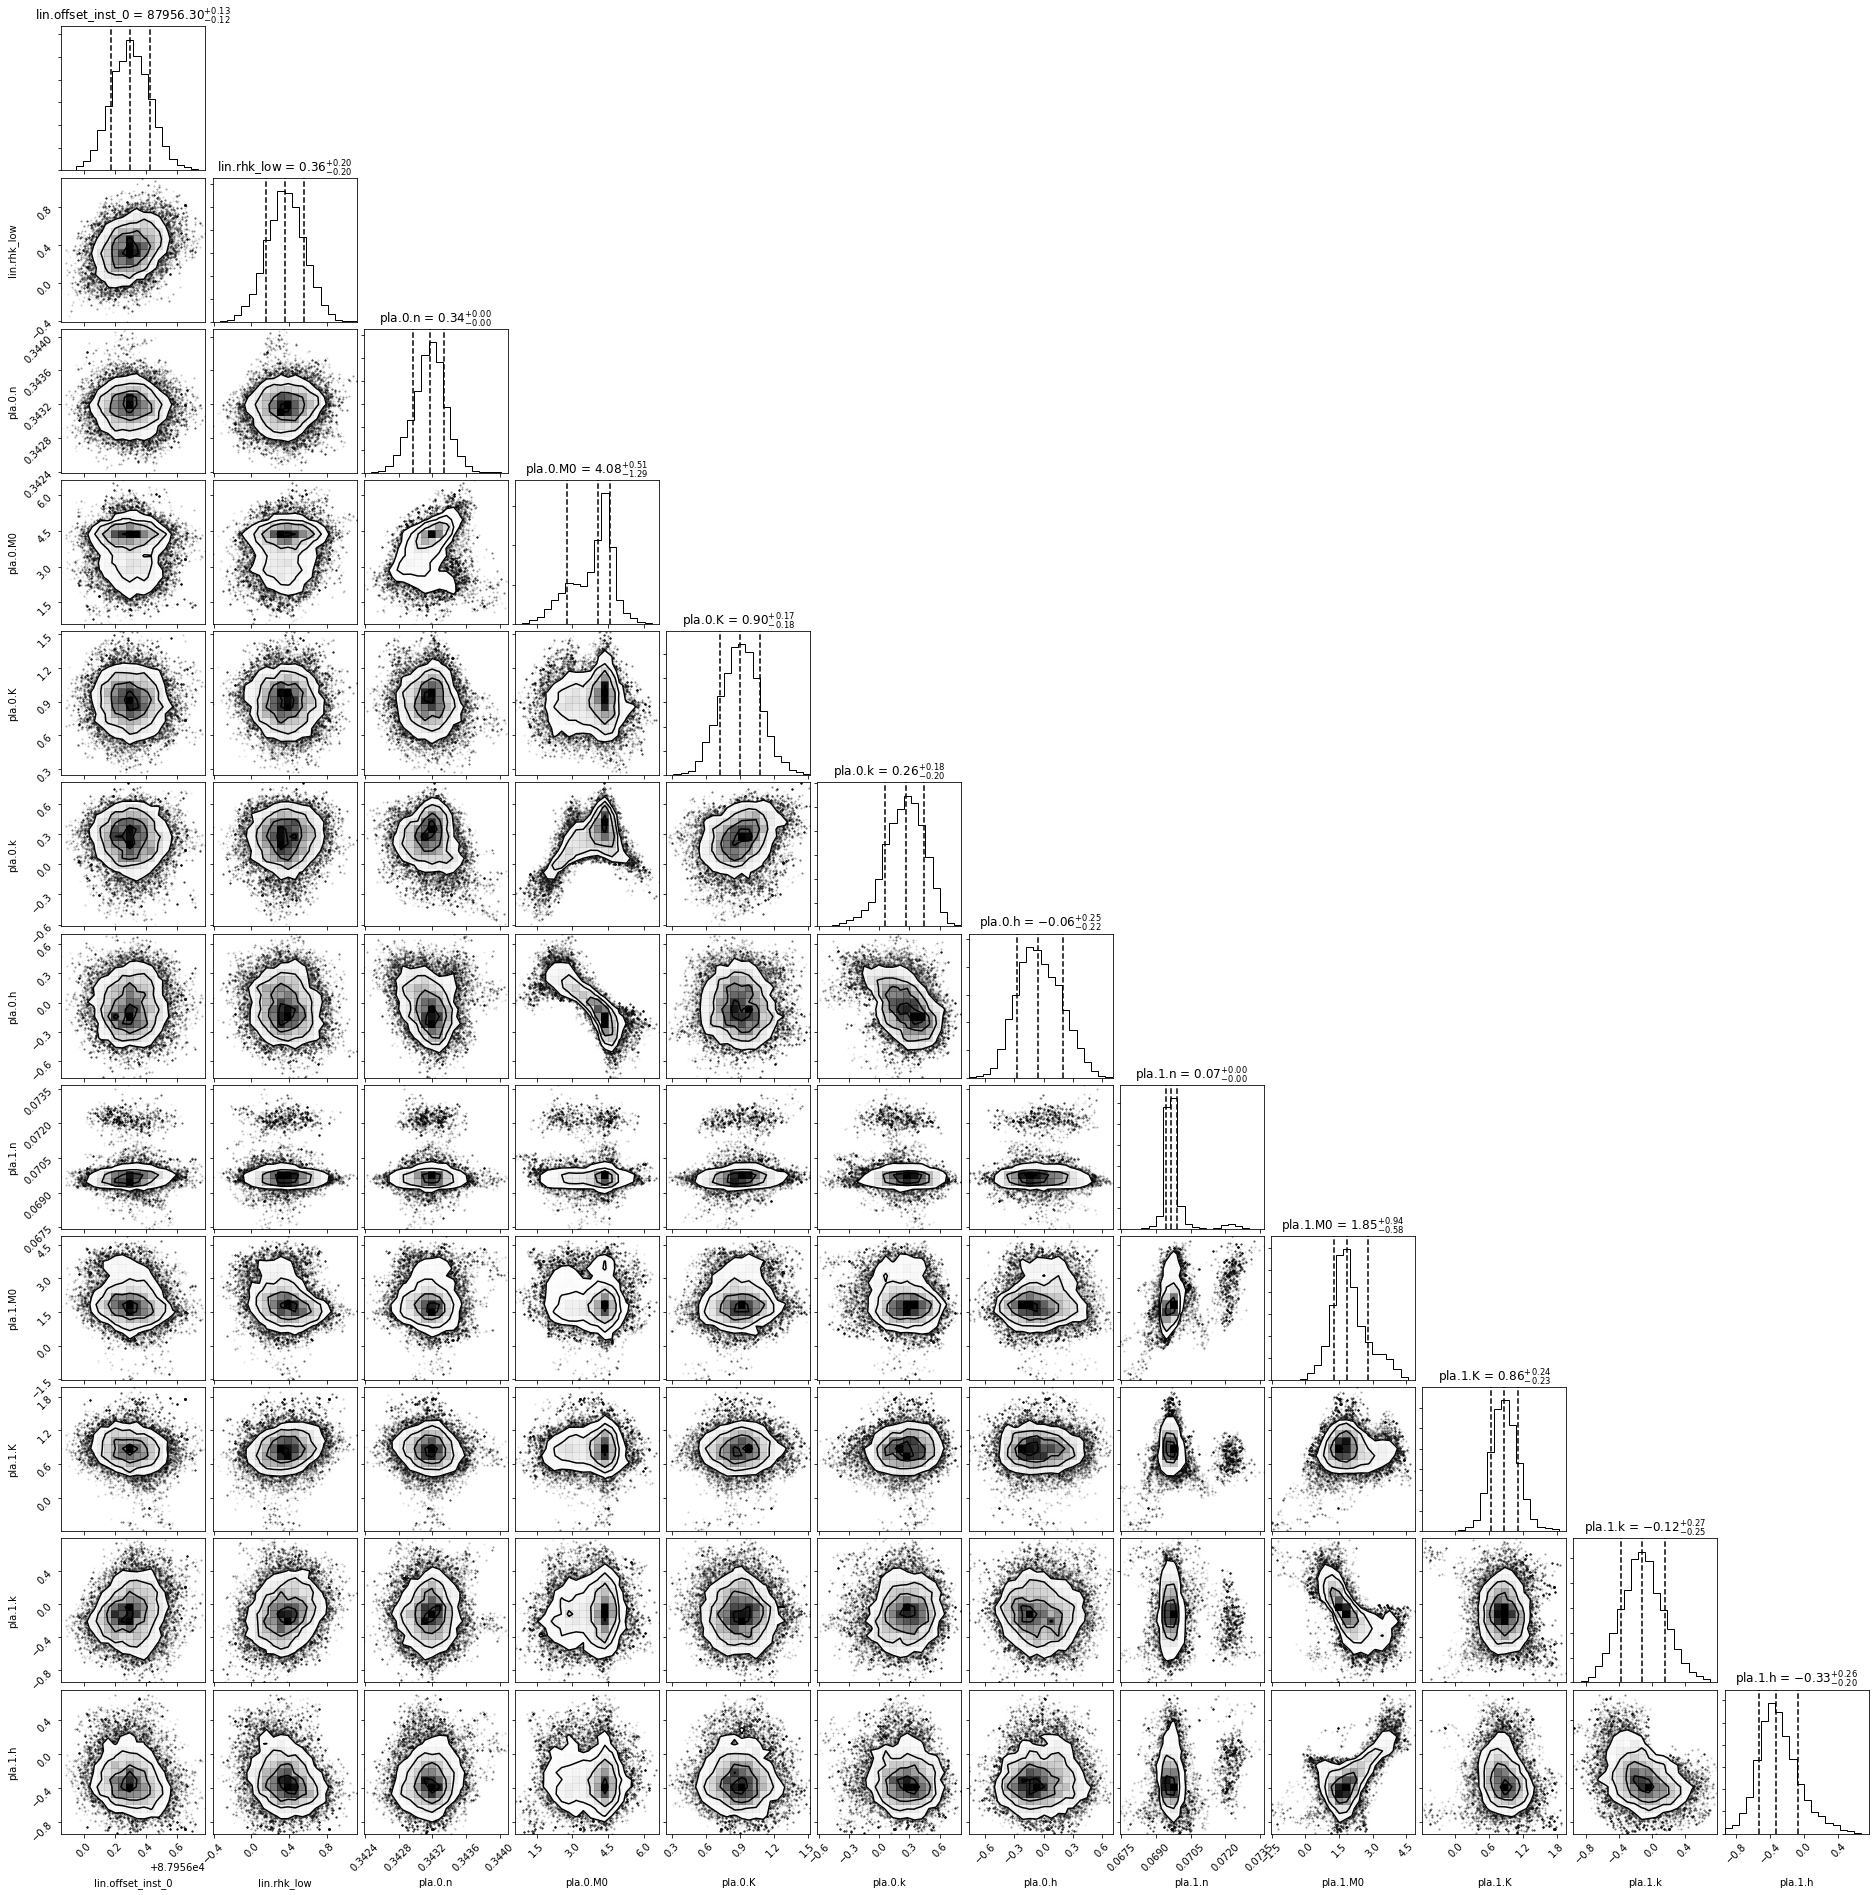

In [13]:
corner.corner(
    samples[nsamples//4:],
    labels=rv_model.fitparams,
    quantiles=[0.159, 0.5, 0.841],
    show_titles=True)
plt.show()
plt.close()